<a href="https://colab.research.google.com/github/Hsuyeon01/ESAA/blob/main/0603_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 회귀 실습 - 자전거 대여 수요 예측

- datetime : hourly date + timestamp
- season : 1=봄, 2=여름, 3=가을, 4=겨울
- holiday : 1=토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날
- workingday : 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일
- weather
  - 1 = 맑음, 약간 구름 낀 흐림
  - 2 = 안개, 안개 + 흐림
  - 3 = 가벼운 눈, 가벼운 비 + 천둥
  - 4 = 심한 눈/비, 천둥/번개
- temp : 온도(섭씨)
- atemp : 체감온도(섭씨)
- humidity : 상대습도
- windspeed : 풍속
- casual : 사전에 등록되지 않은 사용자가 대여한 횟수
- registered : 사전에 등록된 사용자가 대여한 횟수
- count : 대여 횟수

### 데이터 클렌징 및 가공

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


Null 데이터는 없으며, 대부분의 칼럼이 int 또는 float 숫자형인데, datetime 칼럼만 object 형

In [3]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)

bike_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [5]:
drop_columns = ['datetime', 'casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

In [42]:
# 회귀 모델 데이터 세트에 적용

from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_squared_error()를 이용해 RMSE 계싼
def rmse(y, pred) : 
  return np.sqrt(mean_squared_error(y, pred))

# MSE, RMSE, RMSLE를 모두 계싼
def evaluate_regr(y, pred) : 
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y,pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계싼
  mae_val = mean_absolute_error(y, pred)
  print('RMSE : {0:.3f}, RMSE : {1:.3F}, MAE : {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [8]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉬움
def rmsle(y, pred):
  msle = mean_squared_log_error(y, pred)
  rmlse = np.sqrt(mse)
  return rmsle

### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, 
                                                    random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSE : 1.165, RMSE : 140.900, MAE : 105.924


In [12]:
def get_top_error_data(y_test, pred, n_tops=5):
  # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성
  result_df  = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['real_count']-result_df['predicted_count'])

  # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
  print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


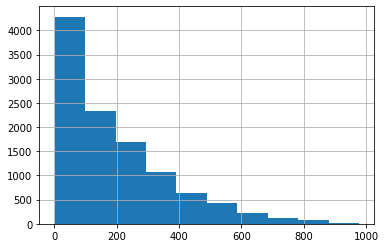

In [13]:
y_target.hist()

count 칼럼 값이 정규 분포가 아닌 0~200 사이에 왜곡돼 있음
-> 로그 변환을 통해 정규 분포로 바꿈

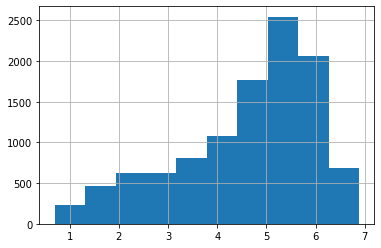

In [14]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [15]:
# 타깃 칼럼인 count 값을 log1p로 로그 변환하기
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 세트 분할하기
X_train,X_test,y_train,y_test = train_test_split(X_features,y_target_log,
                                                 test_size=0.3, random_state=0)
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환하기
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환하기
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSE : 1.017, RMSE : 162.594, MAE : 109.286


RMSLE 오류는 줄어들었지만, RMSE는 늘어남

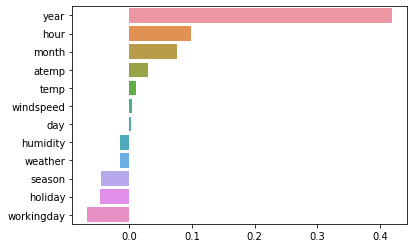

In [17]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- Year 피처의 회귀 계수 값이 독보적으로 큰 값을 가짐
- 이유는 카테리고형 피처지만 숫자형 값으로 돼 있음 -> 원핫인코딩을 통해 변환

In [18]:
# year, month, day, hour등의 피처를 One-Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year','month','day','hour','holiday',
                                                     'workingday', 'season','weather'])

In [19]:
# 원핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할하기
X_train,X_test,y_train,y_test = train_test_split(X_features_ohe, y_target_log,
                                                 test_size=0.3, random_state=0)

# 모델 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환하기
def get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=False):
  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  if is_expm1:
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test,pred)
# end of function get_model_predict

# 모델별로 평가 수행하기
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model,X_train,X_test,y_train,y_test, is_expm1=True)

### LinearRegression ###
RMSE : 0.590, RMSE : 97.688, MAE : 63.382
### Ridge ###
RMSE : 0.590, RMSE : 98.529, MAE : 63.893
### Lasso ###
RMSE : 0.635, RMSE : 113.219, MAE : 72.803


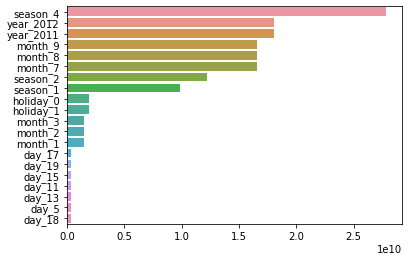

In [20]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

- 선형 회귀 수행 시에는 피처를 어떻게 인코딩하는가가 성능에 큰 영향을 미칠 수 잇음

In [21]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model별로 평가 수행하기
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in (rf_reg,gbm_reg,xgb_reg,lgbm_reg):
  get_model_predict(model,X_train.values,X_test.values,y_train.values,
                    y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSE : 0.355, RMSE : 50.260, MAE : 31.130
### GradientBoostingRegressor ###
RMSE : 0.330, RMSE : 53.324, MAE : 32.737
[05:16:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
### XGBRegressor ###
RMSE : 0.345, RMSE : 58.245, MAE : 35.768
### LGBMRegressor ###
RMSE : 0.319, RMSE : 47.215, MAE : 29.029


- 앞의 선형 회귀 모델보다 회귀 예측 성능이 개선

## 10. 회귀실습 - 캐글 주택 가격 : 고급 회귀 기법


### 데이터 사전 처리

In [35]:
house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [36]:
print('Shape: ', house_df.shape)
print('\n전체 피처 type\n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nnull 칼럼과 그 건수: \n', isnull_series[isnull_series > 0].sort_values(ascending=False))

Shape:  (1460, 81)

전체 피처 type
 object     43
int64      35
float64     3
dtype: int64

null 칼럼과 그 건수: 
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


- 1460개의 레코드와 81개의 피처로 구성
- Target을 제외한 80개의 피처 중 43개가 문자형 나머지가 숫자형
- 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규 분포에서 벗어남

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


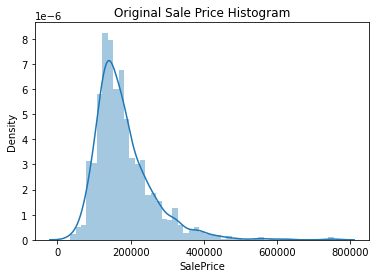

In [31]:
plt.title('Original Sale Price Histogram')
sns.distplot(house_df['SalePrice'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


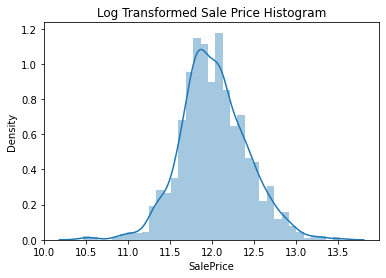

In [32]:
# 로그 변환 적용
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.distplot(log_SalePrice)

- 정규 분포 형태로 결괏값이 분포함

Null값이 많은 피처 삭제, 단순 식별자 Id 삭제

In [37]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature','Alley','Fence','FireplaceQu'], axis=1,
              inplace=True)
# 드롭하지 않는 숫자형 Null 칼럼은 평균값으로 대체
house_df.fillna(house_df.mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type : \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':


In [38]:
# 원핫인코딩
print('get_dummies() 수행 전 데이터 shape: ', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## null 피처의 type: \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape:  (1460, 75)
get_dummies() 수행 후 데이터 shape (1460, 271)
## null 피처의 type: 
 Series([], dtype: object)


- 피처가 75개에서 272개로 증가
- Null 값을 가진 피처 존재 X


### 선형 회귀 모델 학습/예측/평가

- 타깃 값인 SalePrice가 로그 변환됐으므로 예측 값 여깃 로그 변환 값
- 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정됨

In [43]:
 def get_rmse(model): 
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test,pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE: ', np.round(rmse,3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [45]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, 
                                                    random_state=156)

#LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE:  0.132
Ridge 로그 변환된 RMSE:  0.128
Lasso 로그 변환된 RMSE:  0.176


[0.13189576579154202, 0.12750846334052995, 0.17628250556471403]

In [47]:
# 피처별 회귀 계수를 시각화
def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성, index는 칼럼명
  coef = pd.Series(model.coef_, index=X_features.columns)

  # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

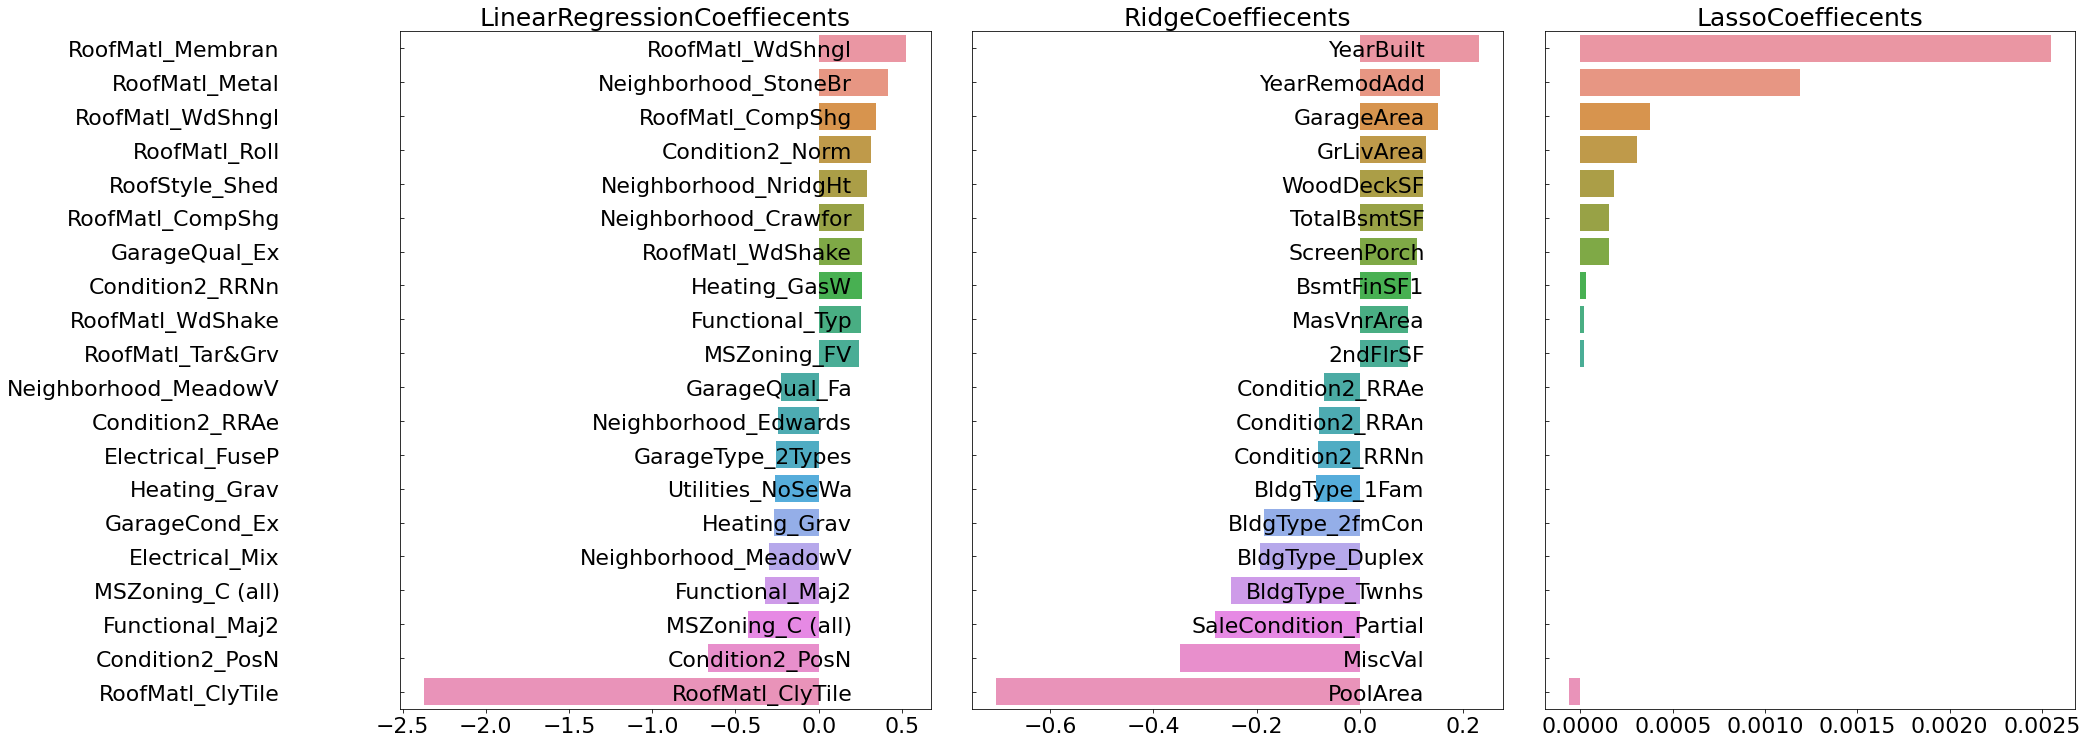

In [49]:
def visualize_coefficient(modles):
  # 3개 회귀 모델의 시각화를 위해 3개 칼럼을 가지는 subplot 생성
  fig,axs = plt.subplots(figsize=(24,10), nrows=1,ncols=3)
  fig.tight_layout()

  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
  for i_num, model in enumerate(models):
    # 상하위 각 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])

    # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
    axs[i_num].set_title(model.__class__.__name__+'Coeffiecents',size=25)
    axs[i_num].tick_params(axis='y', direction='in', pad=120)
    for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
visualize_coefficient(models)

- OLS 기반의 LinearRegression과 Ridge의 경우 회귀 계수가 유사한 형태로 분포
- 라쏘는 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고 다른 피처의 회귀 꼐수는 너무 작음
- 라쏘의 경우 다른 두 개의 모델과 다른 회귀 계수 형태를 보임

In [50]:
# 교차 검증 폴드 세트를 분할해 평균 RMSE 측정

from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

  for model in models:
    # 분할하지 않고 전체 데이터로 cross_val_score() 수행, 모델별 CV RMSE값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                         scoring = 'neg_mean_squared_error', cv=5))
    
    rmse_avg = np.mean(rmse_list)
    print('\n{0} cv RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
    print('{0} cv 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))
  
# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
get_avg_rmse_cv(models)


LinearRegression cv RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression cv 평균 RMSE 값: 0.155

Ridge cv RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge cv 평균 RMSE 값: 0.144

Lasso cv RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso cv 평균 RMSE 값: 0.198


- 라쏘의 경우가 OLS 모델이나 릿지 모델보다 성능이 떨이짐

In [53]:
# alpha 값을 변화시키면서 최저 값 도출
def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params, 
                            scoring = 'neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1 * grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값 : {1}, 최적 alpha: {2}'.format(model.__class__.__name__,
                                                              np.round(rmse,4), grid_model.best_params_))
  
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)
  

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1418, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.142, 최적 alpha: {'alpha': 0.001}


LinearRegression 로그 변환된 RMSE:  0.132
Ridge 로그 변환된 RMSE:  0.124
Lasso 로그 변환된 RMSE:  0.12


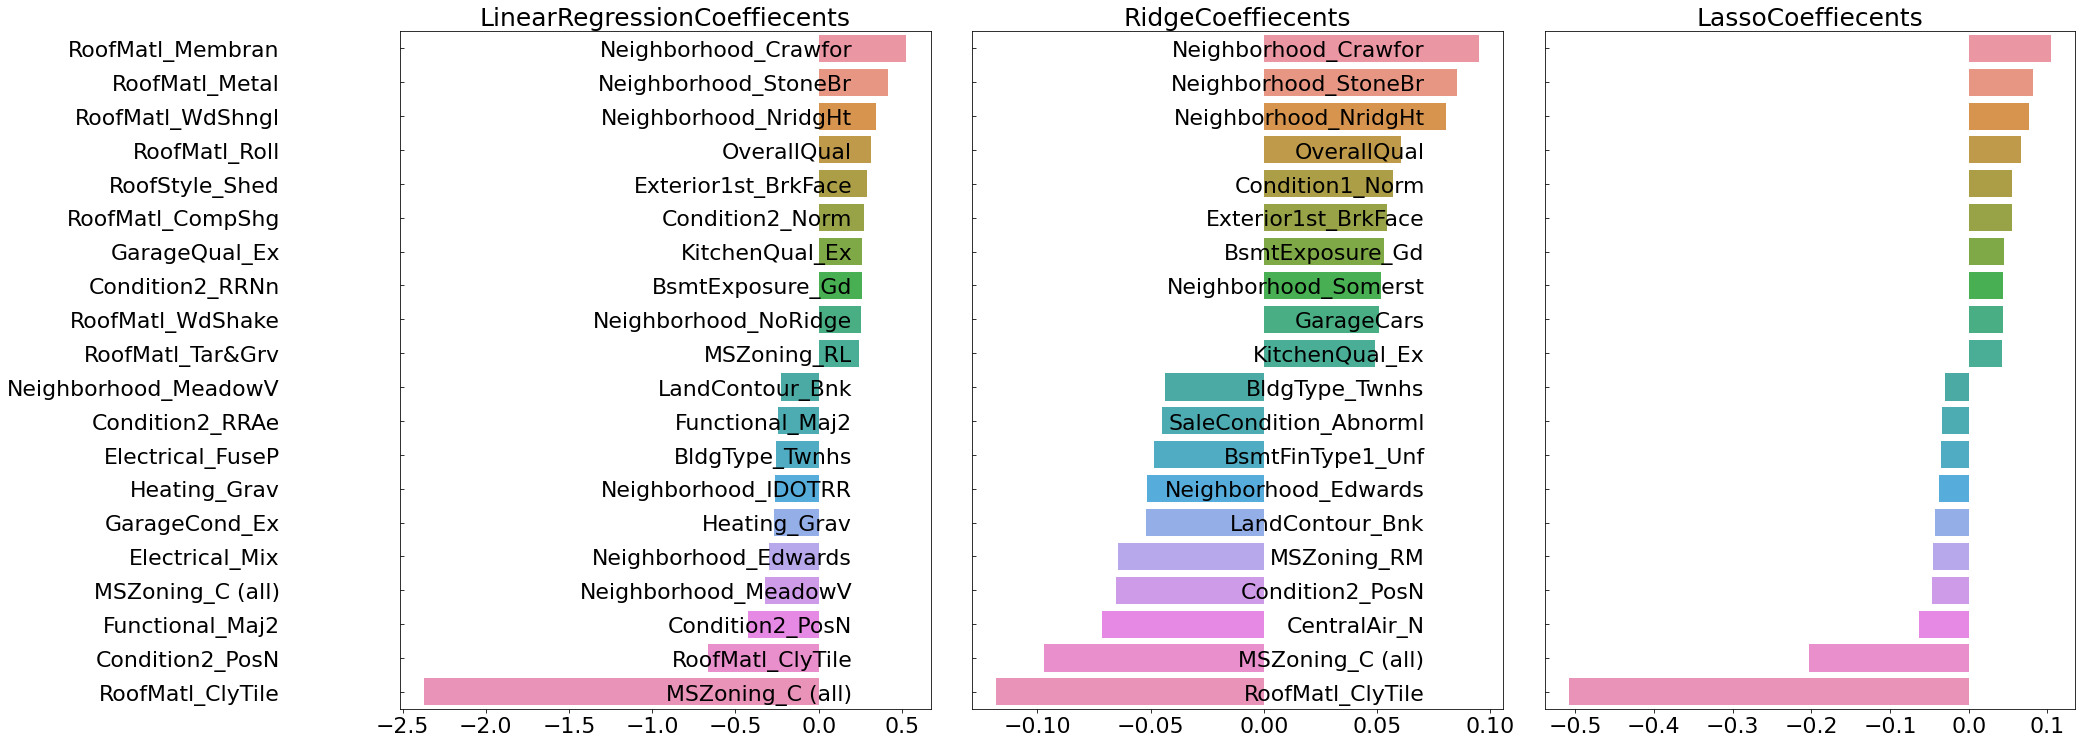

In [55]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
visualize_coefficient(models)

- 테스트 데이터 세트의 예측 성능이 더 좋아짐, 모델별 회귀 계수도 많이 달라짐
- 릿지와 라쏘 모델에서 비슷한 피처의 회귀 계수가 높음

사이파이 stats 모듈의 skew() 함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 쉽게 추출할 수 있음

- 일반적으로 skew() 함수의 반환 값이 1이상인 경우를 왜곡 정도가 높다고 판단하지만, 상황에 따라 편차는 있음
- skew()를 적용하는 숫자형 피처에서 원-핫 인코딩된 카테코리 숫자형 피처는 제외해야 함

In [56]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [57]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [58]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, 
                                                    random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1275, 최적 alpha: {'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1252, 최적 alpha: {'alpha': 0.001}


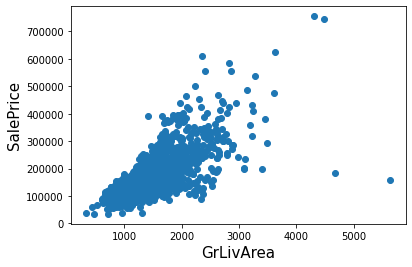

In [59]:
# house_df_org에서 GrLivArea와 타깃 값인 SalePrice의 관계를 시각화

plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

- GrLivArea 피처는 SalePrice와 양의 상관도가 매우 높음을 직관적으로 알 수 있음, 그러나 위 그림에선 두 피처의 관꼐까 어긋나 있음, 이상치 삭제가 필요

In [60]:
# house_df_ohe에서 대상 데이터 필터링
# GridArea와 SalePrice 모두 로그 변환 됐으므로 이를 반영한 조건 생성
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index: ', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape: ', house_df_ohe.shape)

# DataFrame 인덱스를 이용해 이상치 레코드 삭제하기
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape: ', house_df_ohe.shape)

이상치 레코드 index:  [ 523 1298]
이상치 삭제 전 house_df_ohe shape:  (1460, 271)
이상치 삭제 후 house_df_ohe shape:  (1458, 271)


In [61]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, 
                                                    random_state=156)

In [62]:
ridge_params = {'alpha' : [0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha' : [0.001,0.005,0.008,0.05,0.03,0.1,0.5,1,5,10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값 : 0.1125, 최적 alpha: {'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값 : 0.1122, 최적 alpha: {'alpha': 0.001}


예측 수치가 매우 크게 향상


### 회귀 트리 모델 학습/예측/평가

In [63]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5,subsample=0.8)
print_best_params(xgb_reg,xgb_params)

[06:09:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:09:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5 CV 시 최적 평균 RMSE 값 : 0.115, 최적 alpha: {'n_estimators': 1000}


In [64]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4,reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg,lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값 : 0.1161, 최적 alpha: {'n_estimators': 1000}


### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [67]:
def get_rmse_pred(preds):
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y_test, pred_value)
    rmse = np.sqrt(mse)
    print('{0} 모델의 RMSE : {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합' : pred,
         'Ridge' : ridge_pred,
         'Lasso' : lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.10007930884470513
Ridge 모델의 RMSE : 0.10345177546603244
Lasso 모델의 RMSE : 0.10024170460890035


In [72]:
xgb_reg = XGBRegressor(n_estimators=1000,learning_rate=0.05,colsample_bytree=0.5,subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4,reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

[06:20:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [73]:
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합' : pred,
         'XGBM' : xgb_pred,
         'LGBM' : lgbm_pred}
get_rmse_pred(preds)

최종 혼합 모델의 RMSE : 0.09897715854093486
XGBM 모델의 RMSE : 0.10075115846547565
LGBM 모델의 RMSE : 0.1015065721553885


### 스태킹 앙상블 모델을 통한 회귀 예측

스태킹 모델은 두 종류의 모델 필요함
- 개별적인 기반 모델
- 이 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델

핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 데이터 세트를 만드는 것

In [74]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개발 기반 모델에서 최종 메탈 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수 
def get_stacking_base_datasets(model,X_train_n,y_train_n,X_test_n,n_folds):
  # 지정된 n_folds값으로 KFold 생성
  kf = KFold(n_splits=n_folds,shuffle=True,random_state=0)

  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0],n_folds))
  print(model.__class__.__name__,'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트 : ',folder_counter,' 시작 ')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr,y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:,folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred,axis = 1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred,test_pred_mean

In [75]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반 모델이 생성한 학습용/테스트용 데이터 반환
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg,X_train_n,y_train_n,X_test_n,5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg,X_train_n,y_train_n,X_test_n,5)
xgb_train,xgb_test = get_stacking_base_datasets(xgb_reg,X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg,X_train_n,y_train_n,X_test_n,5)

Ridge model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
Lasso model 시작
	 폴드 세트 :  0  시작 
	 폴드 세트 :  1  시작 
	 폴드 세트 :  2  시작 
	 폴드 세트 :  3  시작 
	 폴드 세트 :  4  시작 
XGBRegressor model 시작
	 폴드 세트 :  0  시작 
[06:25:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  1  시작 
[06:25:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  2  시작 
[06:25:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  3  시작 
[06:25:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트 :  4  시작 
[06:25:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBMRegressor model 시작
	 폴드 세트 :  0  시작 
	 

In [76]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합
Stack_final_X_train = np.concatenate((ridge_train,lasso_train,xgb_train,lgbm_train),axis = 1)
Stack_final_X_test = np.concatenate((ridge_test,lasso_test,xgb_test,lgbm_test),axis = 1)

# 최종 메타 모델은 라쏘 모델을 적용
meta_model_lasso = Lasso(alpha = 0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정
meta_model_lasso.fit(Stack_final_X_train,y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test,final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE : ', rmse)

스태킹 회귀 모델의 최종 RMSE :  0.09844866983583922
